## The LLM bot

In [1]:
!module load python
!pip list
!pip install langchain langchain_community langchain_core scholarly pdfplumber langchain_experimental


from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PDFPlumberLoader, TextLoader
from langchain.embeddings import OllamaEmbeddings
from langchain.vectorstores import Chroma
from langchain_community.llms import Ollama
import json
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import PromptTemplate
import requests
from scholarly import scholarly

from langchain_experimental.text_splitter import SemanticChunker


/bin/bash: line 1: module: command not found
Package                                  Version         Editable project location
---------------------------------------- --------------- -------------------------
aiohttp                                  3.9.5
aiosignal                                1.3.1
alabaster                                0.7.16
annotated-types                          0.7.0
anyio                                    4.4.0
argon2-cffi                              23.1.0
argon2-cffi-bindings                     21.2.0
arrow                                    1.3.0
arxiv                                    2.1.3
asgiref                                  3.8.1
asttokens                                2.4.1
async-lru                                2.0.4
attrs                                    23.2.0
Babel                                    2.15.0
backoff                                  2.2.1
backports.tarfile                        1.2.0
bcrypt                          

In [2]:
from langchain_community.document_loaders.pdf import PDFPlumberLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.schema import Document
class Bot_LLM:
    def __init__(self,model='llama3',embed_model='mxbai-embed-large', folder_path='db2'):
        self.llm = Ollama(model=model)
        self.oembed = OllamaEmbeddings(model=embed_model)
        self.folder_path = folder_path
        self.vectorestore = None

    
    def get_topic_publication_abstract(self, abstract:str, input_file:str):
        with open(input_file, 'r') as file:
            data = json.load(file)
        
        parser = JsonOutputParser()
        
        new_text = """The output should be formatted as a JSON instance that conforms to the JSON schema below.

        As an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}
        the object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.

        Here is the output schema:
        ```
        {"topic": {'Machine Learning: [Keyword1, keyword2, keyword3], 'Batteries: [keyword1, keyword2, keyword3]}
        ```
        """


        prompt = PromptTemplate(
            template="Here is a text: {abstract} Please identify the topics from the following list: {liste}. Note: A single text can belong to multiple topics, so please list all relevant topics.  \n{format_instructions}"
        ,
            input_variables=["abstract","liste","topics"],
            partial_variables={"format_instructions": new_text}
        )


        chain = prompt | self.llm | parser
        topics = chain.invoke({"abstract": abstract, "liste": data.keys()})
        print('Topics: ', topics['topic'])
        return topics['topic']

    def decomposition(self, question):
        from langchain.prompts import ChatPromptTemplate
        from langchain_core.output_parsers import StrOutputParser

        # Decomposition
        template = """You are a helpful assistant that generates multiple sub-questions related to an input question. \n
        The goal is to break down the input into a set of sub-problems / sub-questions that can be answers in isolation. \n
        Generate multiple search queries related to: {question} \n
        Output (3 queries):"""
        prompt_decomposition = ChatPromptTemplate.from_template(template)
        generate_queries_decomposition = ( prompt_decomposition | self.llm | StrOutputParser() | (lambda x: x.split("\n")))
        
        questions = generate_queries_decomposition.invoke({"question":question})
        print(questions)
        # Prompt
        template = """Here is the question you need to answer:
        
        \n --- \n {question} \n --- \n
        
        Here is any available background question + answer pairs:
        
        \n --- \n {q_a_pairs} \n --- \n
        
        Here is additional context relevant to the question: 
        
        \n --- \n {context} \n --- \n
        
        Use the above context and any background question + answer pairs to answer the question: \n {question}
        """
        
        decomposition_prompt = ChatPromptTemplate.from_template(template)
        from operator import itemgetter
        
        
        def format_qa_pair(question, answer):
            """Format Q and A pair"""
            
            formatted_string = ""
            formatted_string += f"Question: {question}\nAnswer: {answer}\n\n"
            return formatted_string.strip()
        
        
        q_a_pairs = ""
        for q in questions:
            
            rag_chain = (
            {"context": itemgetter("question") | self.vectorstore.as_retriever(), 
             "question": itemgetter("question"),
             "q_a_pairs": itemgetter("q_a_pairs")} 
            | decomposition_prompt
            | self.llm
            | StrOutputParser())
        
            answer = rag_chain.invoke({"question":q,"q_a_pairs":q_a_pairs})
            q_a_pair = format_qa_pair(q,answer)
            q_a_pairs = q_a_pairs + "\n---\n"+  q_a_pair
            print(q_a_pairs)





    
    def chunk_indexing(self, document:str):
        # Check if the document is a valid file path

        data = []
        if isinstance(document, str) and os.path.isfile(document):
            try:
                loader = PDFPlumberLoader(document)
                data = loader.load()
                chunk_size = 2000
                chunk_overlap = 20

            except Exception as e:
                raise RuntimeError(f"Error loading PDF: {e}")
        else:
            try:
                # Treat the document as raw text content
                if isinstance(document, str):
                    data.append(Document(page_content=document))
                elif isinstance(document, list):
                    for text in document:
                        data.append(Document(page_content=text))
                chunk_size = 180
                chunk_overlap = 5

            except Exception as e:
                raise RuntimeError(f"Error processing text: {e}")

            
        text_splitter=text_splitter = SemanticChunker(
    self.oembed, breakpoint_threshold_type="standard_deviation")


        all_splits = text_splitter.split_documents(data)
        self.vectorstore = Chroma.from_documents(documents=all_splits, embedding=self.oembed, persist_directory=self.folder_path)
        
    def query_rag(self, question:str) -> None:
        if self.vectorstore:
            docs = self.vectorstore.similarity_search(question)
            from langchain.chains import RetrievalQA
            qachain=RetrievalQA.from_chain_type(self.llm, retriever=self.vectorstore.as_retriever(), verbose=True)
            res = qachain.invoke({"query": question})
            print(res['result'])
            return res['result']


        else:
            raise Exception("No documents loaded")





# The Publication Class: 


In [3]:

import os
from bs4 import BeautifulSoup


class Publication:
    def __init__(self,publication_filled, llm_use:bool=True) -> None:
        self.publication_filled = publication_filled
        self.title = self.get_publication_title()
        self.abstract = self.get_publication_abstract().lower()
        self.author = self.get_author_name()
        self.year = self.get_year()
        self.url = self.get_publication_url()
        self.citation = self.get_citation()
        self.pdf = None
        self.topic = None
    
      
      
    '''  
    def get_topic(self,output_file="json/ouput.json", # à voir cette histoire avec get_topic et __get_topic
                  input_file="json/response.json") -> list[str]:
        try:
            with open(output_file,'r') as file:
                data = json.load(file)
            return data[self.author]['topic']
        except Exception as e:
            return self.__get_topic(input_file)
     '''   
    def get_publication_url(self) -> str:
        return self.publication_filled['pub_url']
    
    def get_publication_title(self) -> str:
        return self.publication_filled['bib']['title'] 

    def get_publication_abstract(self) -> str:
        return self.publication_filled['bib']['abstract']

    def get_author_name(self) -> str:
        return self.publication_filled['bib']['author']

    def get_year(self) -> str:
        return self.publication_filled['bib']['pub_year']
    
    def get_citation(self) -> str:
        return self.publication_filled['bib']['citation']
    
    def get_topic(self,llm,input_file="json/response.json") -> None:
        self.topic: dict = llm.get_topic_publication_abstract(abstract=self.abstract,input_file=input_file)
        return self.topic
    
    def get_pdf(self):
        query = self.title.replace(" ", "+")
        url = f"https://scholar.google.com/scholar?q={query}"
        print(url)
        response = requests.get(url)
        if response.status_code == 200:
            html_content = response.text
            try:
                self.pdf = self.__parse_google_scholar(html_content)
            except Exception as e:
                print(f"An error occurred while fetching the PDF link: {e}")


        else:
            print(f"Failed to fetch the page. Status code: {response.status_code}")
            return None

    def __repr__(self) -> str:
        self.available_attributes = {'title': self.title if self.title is not None else 'N/A',
                                     'abstract' : self.abstract if self.abstract is not None else 'N/A',
                                        'author': self.author if self.author is not None else 'N/A',
                                        'year': self.year if self.year is not None else 'N/A',
                                        'url': self.url if self.url is not None else 'N/A',
                                        'citation': self.citation if self.citation is not None else 'N/A',
                                        'pdf': self.pdf if self.pdf is not None else 'N/A',
                                        'topic': self.topic if self.topic is not None else 'N/A'}
        return str(self.available_attributes)


        
    def __parse_google_scholar(self,html_content):

        soup = BeautifulSoup(html_content, 'html.parser')

        a_tags = soup.find_all('a')
        try:
            pdf_link = [a['href'] for a in a_tags if 'href' in a.attrs and '.pdf' in a['href']][0]
            print(f"PDF link found: {pdf_link}")
            return pdf_link
        except Exception as e:
            print(f"An error occurred while parsing the PDF link: {e}")
        
        
    
    def download_pdf(self,path):
        
        # Verifier si le path exist sinon le creer
        
        import os
        import requests
        
        
        path = path + self.title + ".pdf"
        if self.pdf is not None:
            try:
                response = requests.get(self.pdf)
                if response.status_code == 200:
                    with open(path, 'wb') as file:
                        file.write(response.content)
                    print(f"PDF successfully downloaded and saved to {path}")
                else:
                    print(f"Failed to download the PDF. HTTP Status Code: {response.status_code}")

            except requests.exceptions.RequestException as e:
                print(f"An error occurred while downloading the PDF: {e}")
        else:
            from scidownl import scihub_download
            #  scidownl by title
            try:
                scihub_download(self.title, paper_type="title", out=path)
            except:
                try:
                    # By URL
                    scihub_download(self.pdf, out=path)
                except:
                    print("Couldn't download the PDF")
           

        
        
    
     
                    
            
        

# The Author



In [4]:



class Author:
    def __init__(self, author):
        """
        Initialize an Author object.

        Args:
            author (str): The name of the author.
        """
        self.author_name = author
        
    def __repr__(self):
        """
        Return a string representation of the Author object.

        Returns:
            str: The name of the author.
        """
        return self.author_name

    def get_last_publication(self):
        """
        Get the last publication of the author.

        Returns:
            dict: A dict containing information about the last publication.
        """
        search_query = scholarly.search_author(self.author_name)
        first_author_result = next(search_query)
        author = scholarly.fill(first_author_result)
        first_publication = sorted(author['publications'], 
                                   key=lambda x: int(x['bib']['pub_year'])
                                   if 'pub_year' in x['bib'] else 0, 
                                   reverse=True)[0]
        first_publication_filled = scholarly.fill(first_publication)
        return first_publication_filled

    def setup_author(self, output_file, llm):
        """
        Setup the author by adding their last publication to a JSON file.

        Args:
            output_file (str): The path to the JSON file.

        Returns:
            None
        """
        with open(output_file, 'r') as file:
            data = json.load(file)
        author_last_publication = Publication(self.get_last_publication())
        

        
        data[self.author_name] = {
            "title": author_last_publication.title,
            "abstract": author_last_publication.abstract,
            "topic": author_last_publication.get_topic(llm=llm), 
            "author": author_last_publication.author, 
            "year": author_last_publication.year,
            "url": author_last_publication.url,
            "pdf": author_last_publication.pdf,
        }
        
        
        with open(output_file, 'w') as file:
            json.dump(data, file)

'''
author = Author('Mehrad Ansari')
pub = Publication(author.get_last_publication())

pub.download_pdf('pdfs/')
'''


"\nauthor = Author('Mehrad Ansari')\npub = Publication(author.get_last_publication())\n\npub.download_pdf('pdfs/')\n"

## Main module to test function:


In [5]:
# Creating the LLM


"""
llm = Bot_LLM()


author = Author('Mehrad Ansari')

print("Author object created successfully \n \n")

pub = Publication(author.get_last_publication())


print("Publication object created successfully - Having fetched the last publication \n \n")

print('current available attributes: \n \n')
print(pub)

print('\n \nRunning LLM on the abstract of the publication \n \n')
pub.get_topic(llm=llm)
print('current available attributes: \n \n')
print(pub)
"""

'\nllm = Bot_LLM()\n\n\nauthor = Author(\'Mehrad Ansari\')\n\nprint("Author object created successfully \n \n")\n\npub = Publication(author.get_last_publication())\n\n\nprint("Publication object created successfully - Having fetched the last publication \n \n")\n\nprint(\'current available attributes: \n \n\')\nprint(pub)\n\nprint(\'\n \nRunning LLM on the abstract of the publication \n \n\')\npub.get_topic(llm=llm)\nprint(\'current available attributes: \n \n\')\nprint(pub)\n'

### Getting PDF - Optional

In [6]:
"""
import os
# Fetching PDF

def check_and_create_directory(path):
    
    if not os.path.exists(path):
        # If it doesn't exist, create the directory
        os.makedirs(path)
        print(f"Directory {path} created.")
    else:
        print(f"Directory {path} already exists.")


pub.get_pdf()
print('current available attributes: \n \n')
print(pub)

# Downloading PDF
current_directory = os.getcwd()

print(f"The current working directory is: {current_directory}")

path = current_directory + '/pdfs/'

check_and_create_directory(path)

pub.download_pdf(path)

print(pub)
"""

'\nimport os\n# Fetching PDF\n\ndef check_and_create_directory(path):\n    \n    if not os.path.exists(path):\n        # If it doesn\'t exist, create the directory\n        os.makedirs(path)\n        print(f"Directory {path} created.")\n    else:\n        print(f"Directory {path} already exists.")\n\n\npub.get_pdf()\nprint(\'current available attributes: \n \n\')\nprint(pub)\n\n# Downloading PDF\ncurrent_directory = os.getcwd()\n\nprint(f"The current working directory is: {current_directory}")\n\npath = current_directory + \'/pdfs/\'\n\ncheck_and_create_directory(path)\n\npub.download_pdf(path)\n\nprint(pub)\n'

### Feeding it to the LLM

We're Checking first if we got the PDF already; we're feeding it to the LLM. If we don't we give it the abstract

In [7]:
import json
def benchmarking(file, index):    
    llm = Bot_LLM(folder_path='db/db'+str(index))
    llm.chunk_indexing(file)    
    #llm.folder_path = txt
    dico = {}
    ## Querying the RAG
    dico['affiliation'] = llm.query_rag("What are the authors affiliation. Output a dictionary ?")
    print("-----")
    dico['topic']  = llm.query_rag("What are topics of the paper ?")
    
    print("-----")
    dico['new materials'] = llm.query_rag("does the article mention any new material discovery ?")
    print("-----")
    dico['screening algorithms'] = llm.query_rag("A screening algorithm is a systematic procedure or method used to identify individuals who may have or be at risk for a particular condition or trait within a large population. These algorithms are designed to quickly and efficiently screen out those who are unlikely to have the condition, while identifying those who may require further diagnostic evaluation or intervention. If there are any, What are the screening algorithms used in the paper ?")
    print("-----")
    dico['AI algorithms'] = llm.query_rag("AI algorithms are computational methods and processes used to solve specific tasks by mimicking human intelligence. These algorithms enable machines to learn from data, make decisions, and perform tasks that typically require human intelligence.")
    print("-----")
    
    dico['workflow'] = llm.query_rag("Can you describe to me the workflow used by the author ?")
    print("-----")
    dico['methods'] = llm.query_rag("can you do a methods description ?")
    print("-----")
    dico['models'] = llm.query_rag("what are the models used in the article ?")
    print("-----")
    dico['funding'] = llm.query_rag("does the article mention who funded it")
    print("-----")
    print(dico)
    return dico


import glob
files_in_dir = glob.glob('pdfs'+ "/*")
dico_response = {}


def load_json_data(json_file_path):
    with open(json_file_path, 'r') as json_file:
        data = json.load(json_file)
    return data

dico_response = load_json_data('benchmarking.json')
i = 1
true_index = 40
for index,file in enumerate(files_in_dir):
    print(index,file)
    try:
        if file.split('/')[1] not in dico_response:
            print(true_index,file)
            true_index += 1
            dico_response[file.split('/')[1]] = benchmarking(file,true_index)
        else:
            print("file already done")
    except Exception as e:
        print(e)
        dico_response[file.split('/')[1]] = None
    print(file+" done")
        
with open('benchmarking.json', 'w') as json_file:
    json.dump(dico_response, json_file)

0 pdfs/cell_penetration_of_oxadiazole_containing_macrocycles.pdf
file already done
pdfs/cell_penetration_of_oxadiazole_containing_macrocycles.pdf done
1 pdfs/DNA-encoded library-enabled discovery of proximity-inducing small molecules.pdf
file already done
pdfs/DNA-encoded library-enabled discovery of proximity-inducing small molecules.pdf done
2 pdfs/photoresponsive_organic_cages_computationally_driven_discovery_of_azobenzene_derived_organic_cages.pdf
file already done
pdfs/photoresponsive_organic_cages_computationally_driven_discovery_of_azobenzene_derived_organic_cages.pdf done
3 pdfs/Big_data_and_benchmarking_initiatives_to_bridge_the_gap_from_AlphaFold_to_drug_design.pdf
file already done
pdfs/Big_data_and_benchmarking_initiatives_to_bridge_the_gap_from_AlphaFold_to_drug_design.pdf done
4 pdfs/evaluating_the_feasibility_of_medium_chain_oleochemical_synthesis_using_microbial_chain_elongation.pdf
file already done
pdfs/evaluating_the_feasibility_of_medium_chain_oleochemical_synthesis

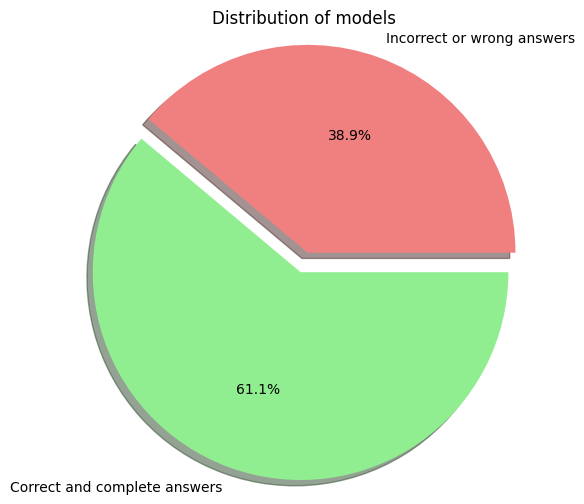

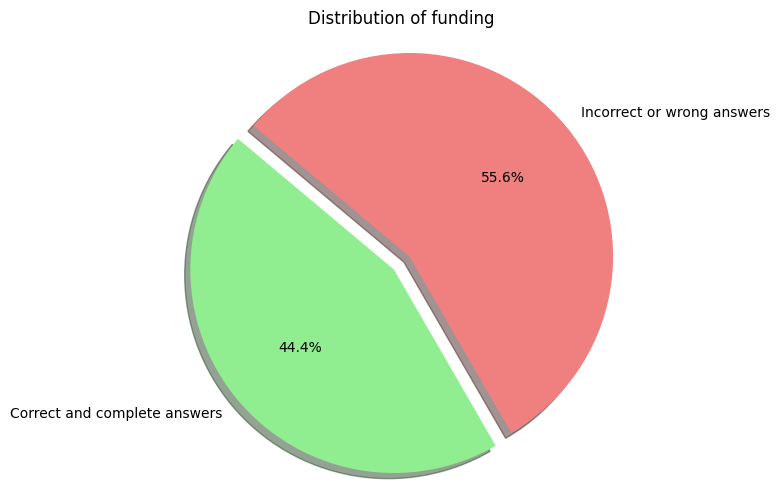

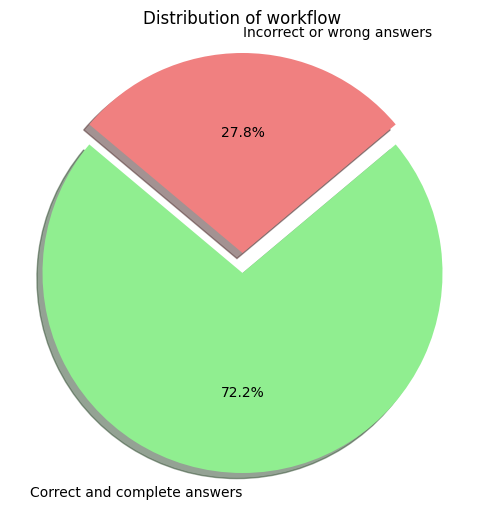

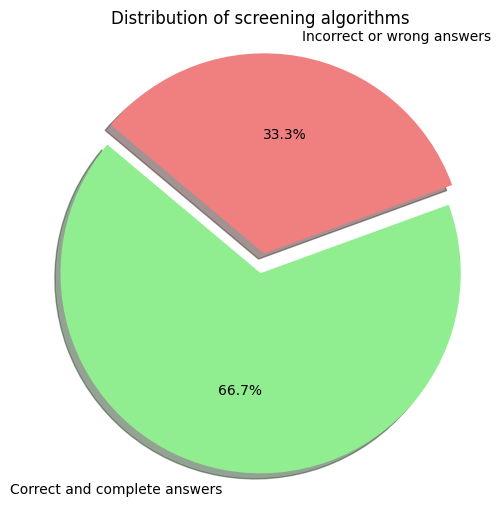

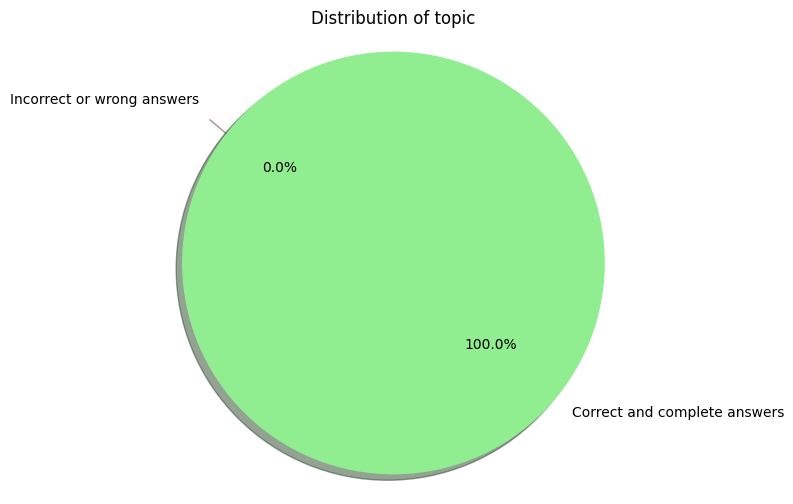

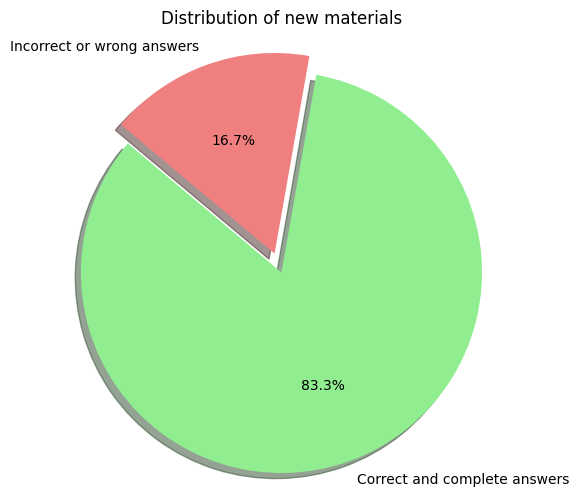

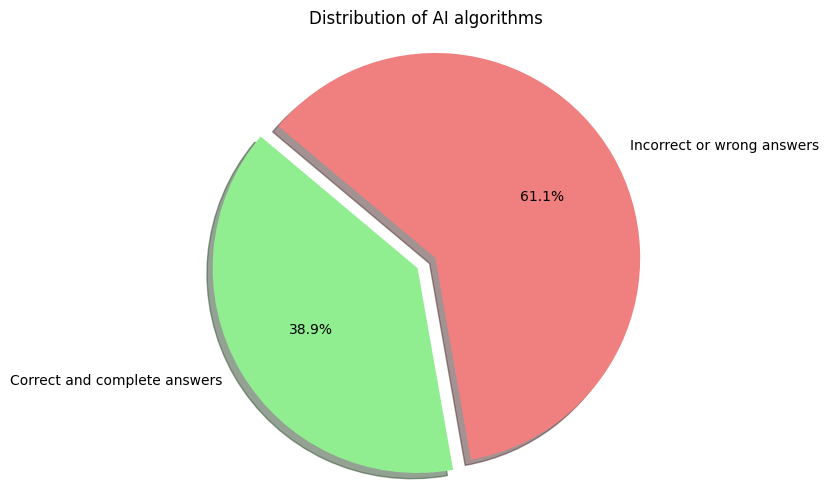

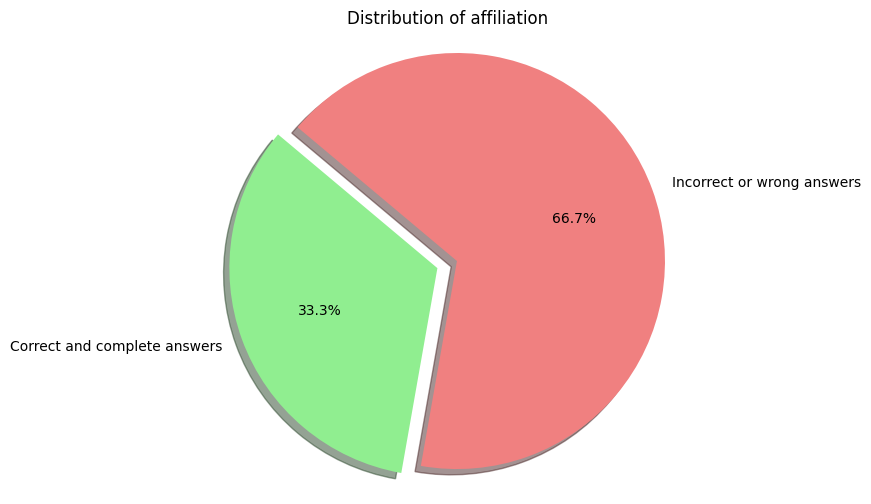

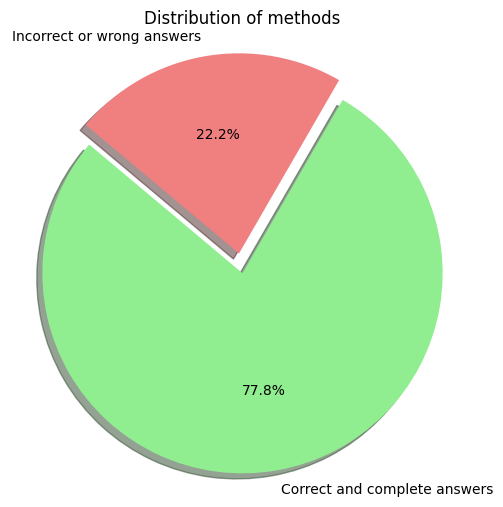

In [ ]:
!pip install matplotlib

import json
import matplotlib.pyplot as plt


def load_json_data(json_file_path):
    with open(json_file_path, 'r') as json_file:
        data = json.load(json_file)
    return data



data:dict = load_json_data('benchmarking_results.json')
data1: dict = load_json_data('benchmark_result1.json')

metrics = set()
for entry in data.values():
    metrics.update(entry.keys())

# Prepare data for each metric
metric_data = {metric: {"Yes": 0, "No": 0} for metric in metrics}

data.update(data1)

for entry in data.values():
    for metric, value in entry.items():
        try:
            metric_data[metric][value] += 1
        except:
            continue
        

# Plotting pie charts
for metric, counts in metric_data.items():
    labels = ["Correct and complete answers","Incorrect or wrong answers"]
    sizes = counts.values()
    colors = ['lightgreen', 'lightcoral']
    explode = (0.1, 0)  # explode 1st slice

    plt.figure(figsize=(6, 6))
    plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
            shadow=True, startangle=140)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title(f'Distribution of {metric}')
    plt.show()

